In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


You can find the original data here --> [Data source](https://data.sfgov.org/Public-Safety/Traffic-Crashes-Resulting-in-Injuries/kn4t-hihx)

# Data Exploration

In [46]:
data = pd.read_csv('./crash_data.csv')

In [47]:
data.head()

,unique_id,cnn_intrsctn_fkey,cnn_sgmt_fkey,case_id_pkey,tb_latitude,tb_longitude,geocode_source,geocode_location,collision_datetime,collision_date,...,party2_move_pre_acc,point,data_as_of,data_updated_at,data_loaded_at,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods
0,73551,22882000.0,4060000.0,230884432,37.743586,-122.463710,SFPD-INTERIM DB,CITY STREET,12/18/2023 02:15:00 PM,2023 December 18,...,Backing,POINT (-122.46370951 37.743585526),02/16/2024 12:00:00 AM,02/16/2024 12:00:00 AM,02/16/2024 04:12:43 PM,49.0,49.0,10.0,8.0,41.0
1,23055,23838000.0,NaN,150060071,37.781750,-122.396380,SFPD-CROSSROADS,CITY STREET,01/20/2015 10:07:00 AM,2015 January 20,...,Making Right Turn,POINT (-122.396379519 37.781750283),01/20/2015 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,32.0,32.0,1.0,10.0,8.0
2,41755,27803000.0,1977000.0,130332135,37.761830,-122.503878,SFPD-CROSSROADS,CITY STREET,04/23/2013 11:26:00 AM,2013 April 23,...,Parked,POINT (-122.503877741 37.761830418),04/23/2013 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,39.0,39.0,10.0,7.0,35.0
3,24743,30739000.0,8747203.0,3348111,37.783992,-122.408066,SFPD-CROSSROADS,CITY STREET,08/22/2007 10:30:00 PM,2007 August 22,...,NaN,POINT (-122.408066364 37.783992037),08/22/2007 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,19.0,19.0,5.0,10.0,34.0
4,30142,26494000.0,6039101.0,4395868,37.785291,-122.424770,SFPD-CROSSROADS,CITY STREET,09/03/2009 01:35:00 PM,2009 September 03,...,Parked,POINT (-122.424770266 37.785291007),09/03/2009 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,100.0,100.0,4.0,11.0,39.0


In [48]:
print(data.isnull().sum())

unique_id                           0
cnn_intrsctn_fkey                  51
cnn_sgmt_fkey                   32166
case_id_pkey                        0
tb_latitude                       198
tb_longitude                      198
geocode_source                      0
geocode_location                    0
collision_datetime                  0
collision_date                      0
collision_time                     58
accident_year                       0
month                               0
day_of_week                         8
time_cat                           52
juris                               0
officer_id                       1076
reporting_district               6510
beat_number                      4503
primary_rd                          0
secondary_rd                       99
distance                           79
direction                           1
weather_1                           0
weather_2                         796
collision_severity                  0
type_of_coll

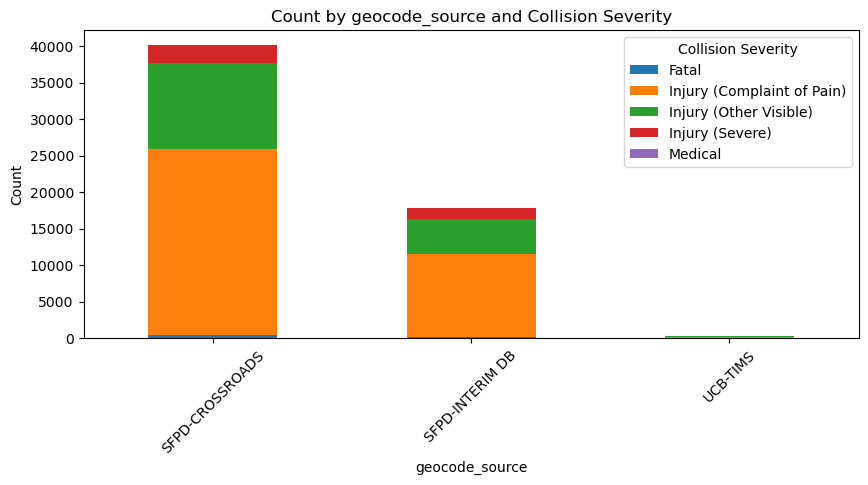

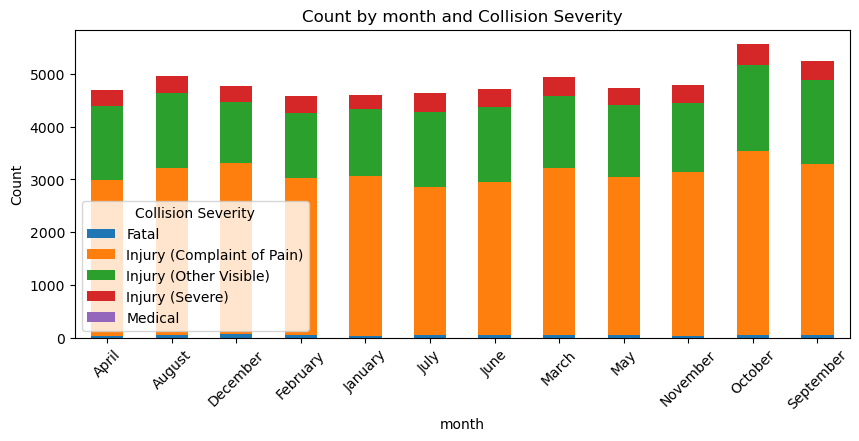

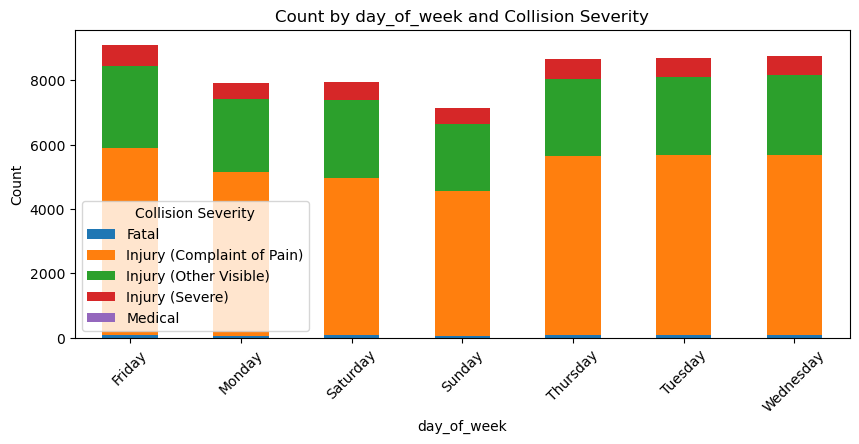

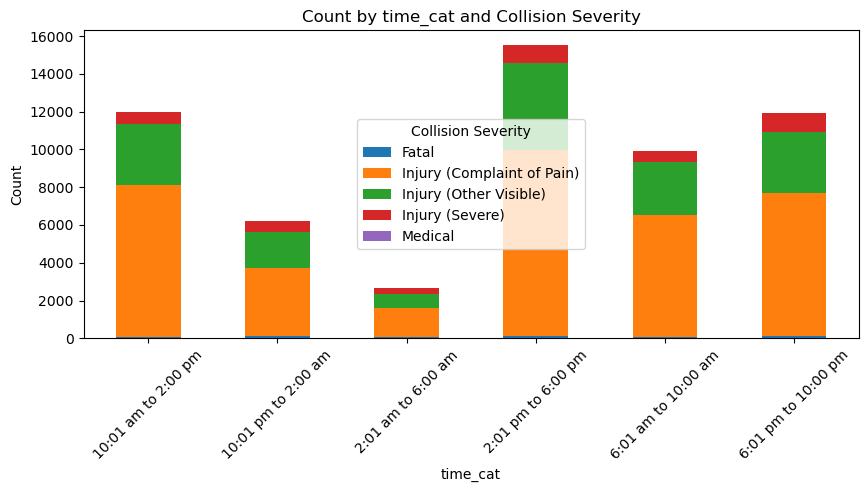

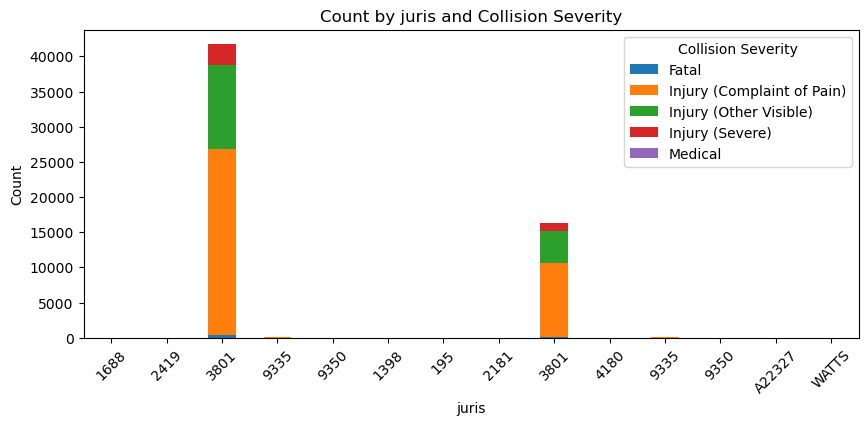

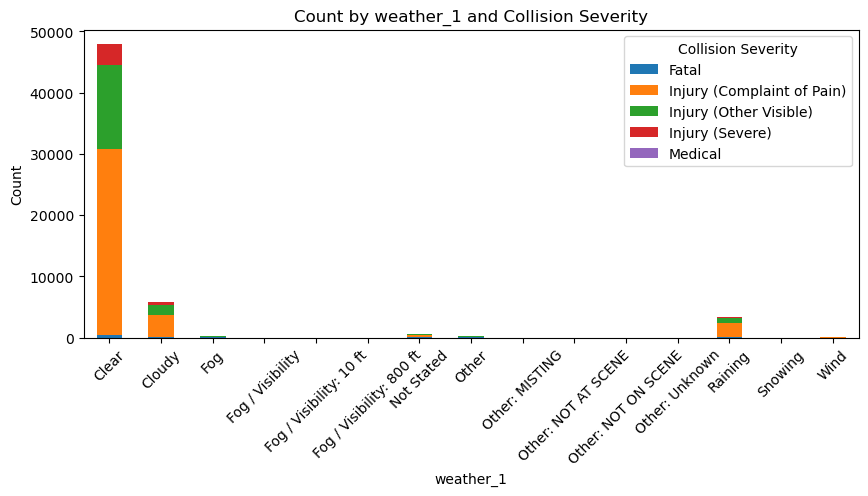

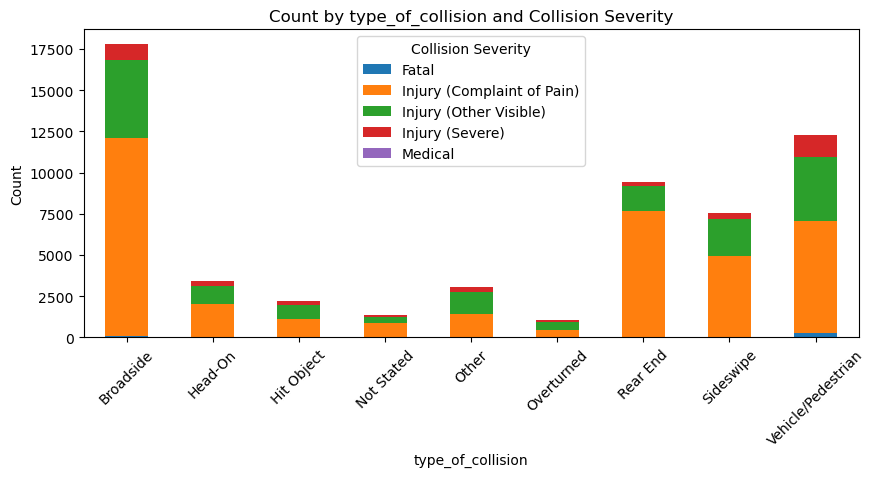

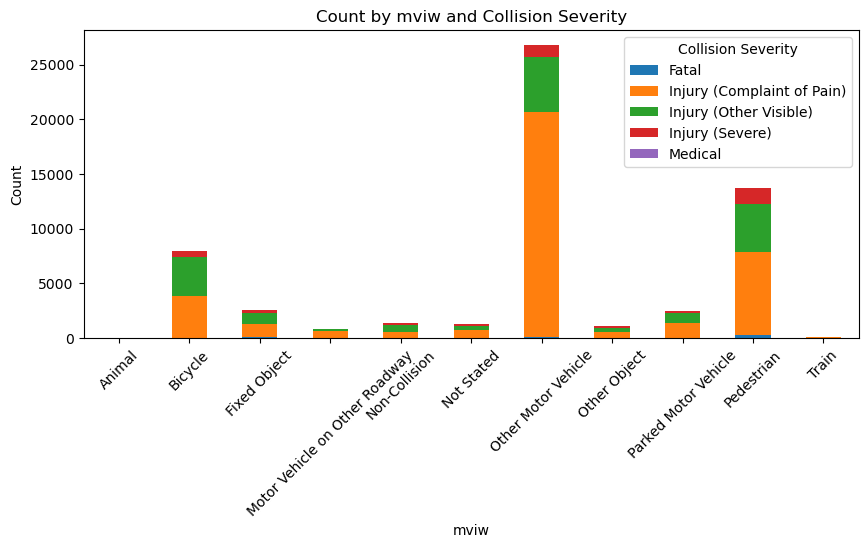

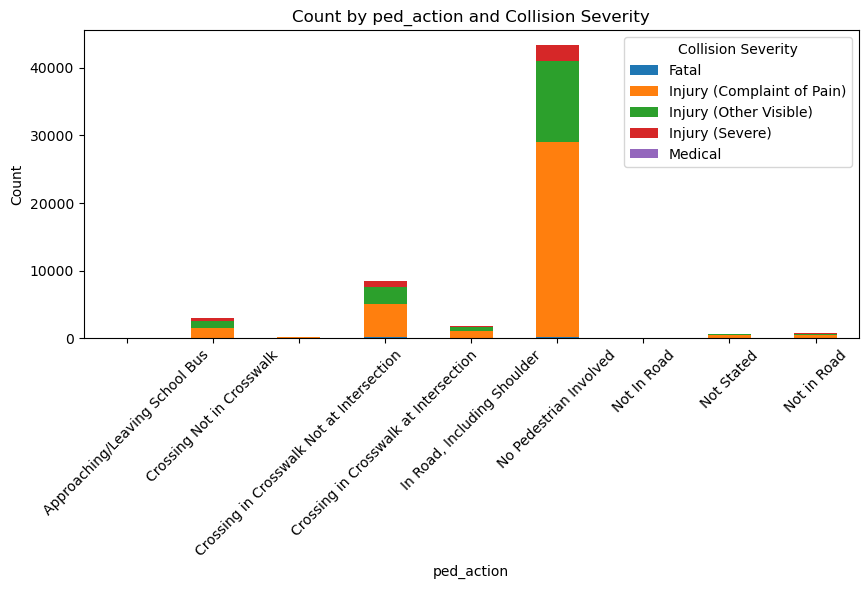

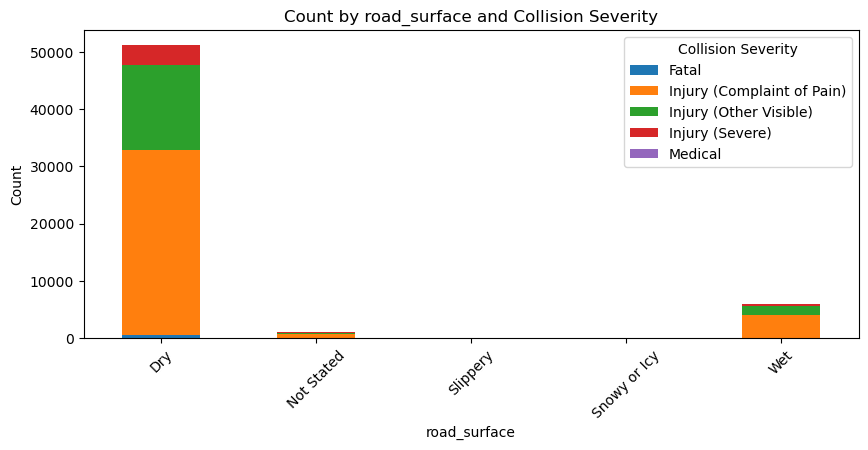

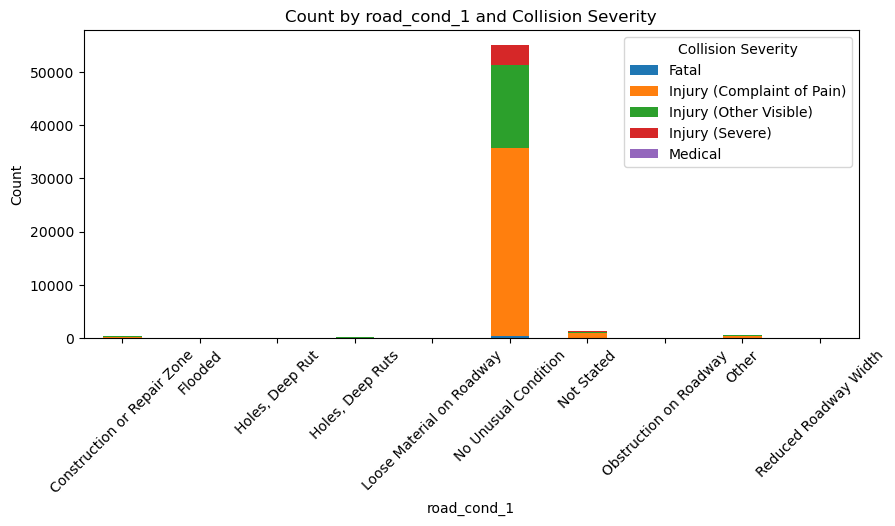

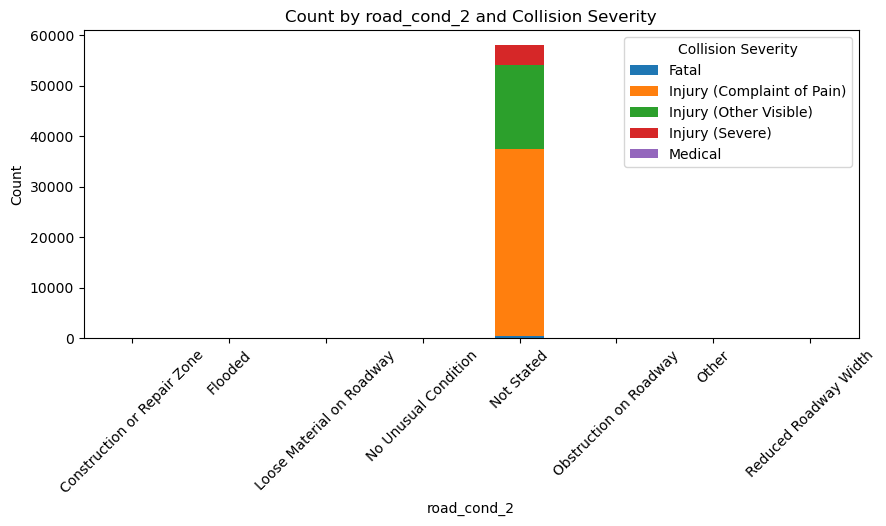

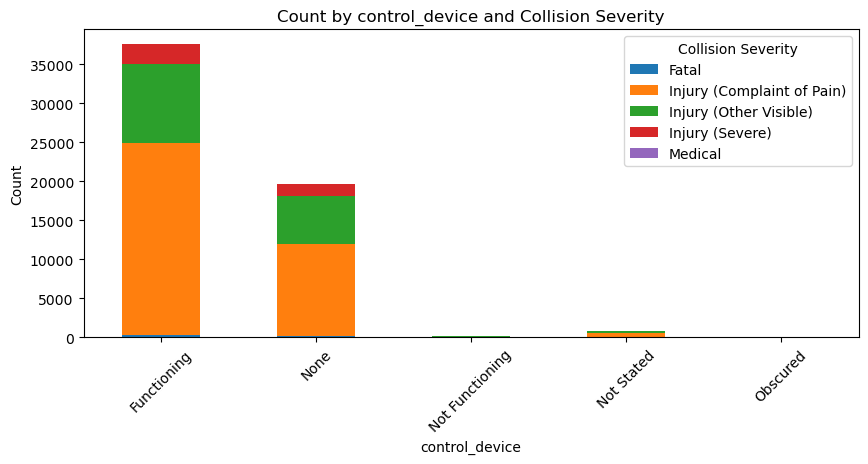

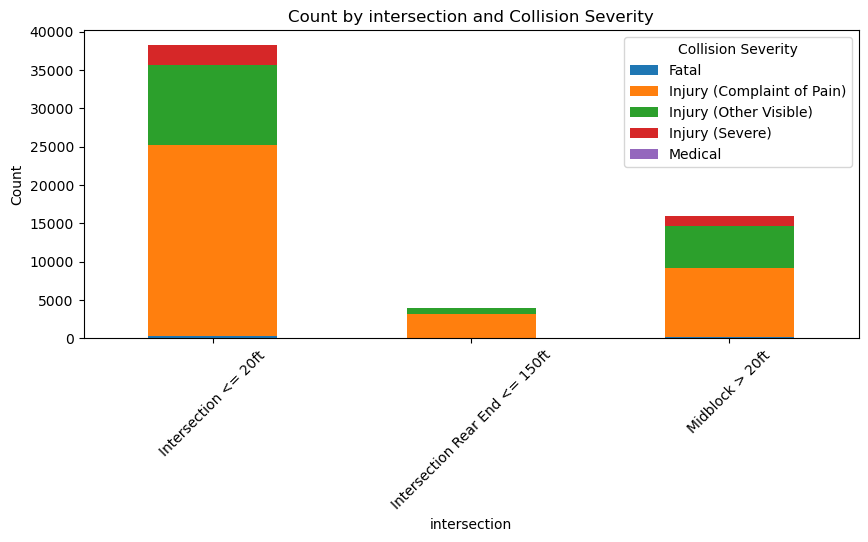

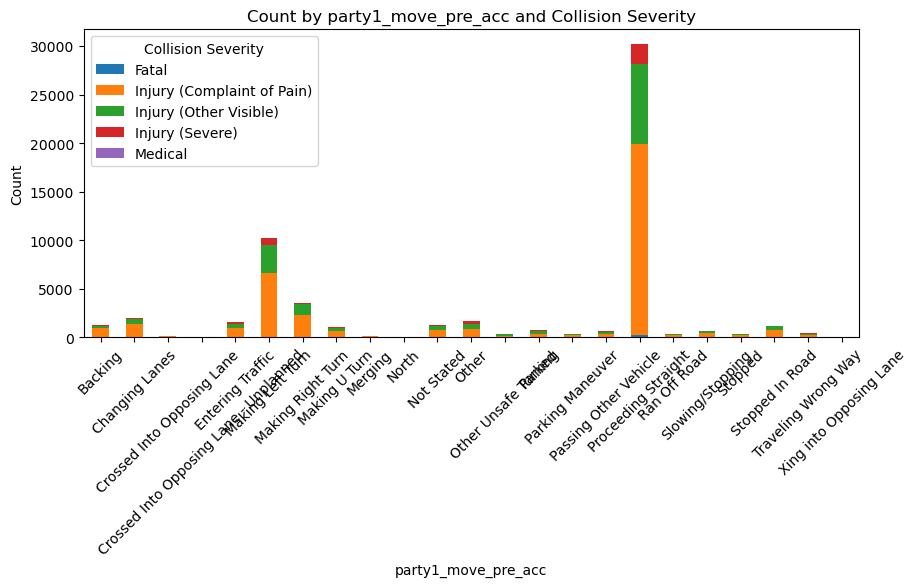

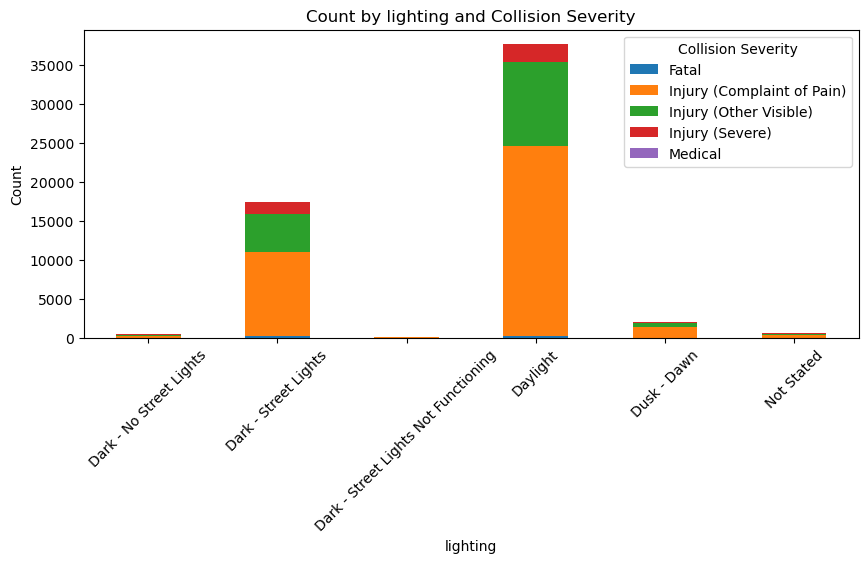

In [49]:
# Number of Incidents based on collision severity for major fields

#These are the columns that were selected based on the initial knowledge on the case
cat_cols = ["geocode_source","month","day_of_week", "time_cat","juris", "weather_1", "type_of_collision",
            "mviw", "ped_action", "road_surface", "road_cond_1", "road_cond_2", "control_device",
            "intersection", "party1_move_pre_acc","lighting"]

for col in cat_cols:
    # Group by the current categorical column AND 'collision_severity', then count the records
    grouped_data = data.groupby([col, 'collision_severity']).size().reset_index(name='counts')
    
    # Pivot this data so that 'collision_severity' values become column headers
    # This will fill missing values with 0, assuming not every category has every severity level
    pivoted_data = grouped_data.pivot(index=col, columns='collision_severity', values='counts').fillna(0)
    
    # Plotting the stacked bar chart with 'collision_severity' levels as the stacks
    pivoted_data.plot(kind='bar', stacked=True, figsize=(10, 4))
    plt.title(f'Count by {col} and Collision Severity')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Collision Severity')
    plt.show()


# Data Modeling

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.metrics import precision_score, recall_score

We planned to run the Logistic Regression on the below combination of fields based on our EDA


['month', 'day_of_week', 'weather_1'] - Basic time and weather conditions.<br>
['lighting', 'road_surface', 'weather_1'] - Environmental conditions.<br>
['type_of_collision', 'mviw'] - Collision type and involved party.<br>
['time_cat', 'intersection'] - Time of day and intersection type.<br>
['day_of_week', 'type_of_collision', 'lighting'] - Weekly pattern, collision type, and lighting.<br>
['weather_1', 'road_surface', 'lighting', 'intersection'] - Comprehensive environmental conditions.<br>
['month', 'day_of_week', 'type_of_collision', 'mviw', 'weather_1'] - Time, collision type, involved party, and weather.<br>
['time_cat', 'type_of_collision', 'lighting', 'road_surface'] - Time of day, collision type, and environmental conditions.<br>
['mviw', 'intersection', 'lighting'] - Involved party, intersection type, and lighting.<br>
['day_of_week', 'weather_1', 'road_surface', 'lighting', 'type_of_collision'] - Weekly pattern with environmental conditions and collision<br> type.

In [51]:
df = data.copy()

# Feature Engineering --> Map 'collision_severity' to binary 'level'
df['level'] = df['collision_severity'].map({
    'Injury (Severe)': 1, 'Fatal': 1, 'Medical': 1,
    'Injury (Other Visible)': 0, 'Injury (Complaint of Pain)': 0
})

# Preprocessing: Dropping unnecessary columns
df.drop(['unique_id', 'number_injured', 'collision_severity'], axis=1, inplace=True)

In [70]:
# Define combinations of columns to test, including and excluding 'primary_rd'
feature_combinations = [
    ['month', 'day_of_week', 'weather_1'],
    ['lighting', 'road_surface', 'weather_1'],
    ['type_of_collision', 'mviw'],
    ['time_cat', 'intersection'],
    ['day_of_week', 'type_of_collision', 'lighting'],
    ['weather_1', 'road_surface', 'lighting', 'intersection'],
    ['month', 'day_of_week', 'type_of_collision', 'mviw', 'weather_1'],
    ['time_cat', 'type_of_collision', 'lighting', 'road_surface'],
    ["party1_move_pre_acc","party2_move_pre_acc", "intersection", "lighting"],
    ['mviw', 'intersection', 'lighting'],
    ['day_of_week', 'weather_1', 'road_surface', 'lighting', 'type_of_collision'],
    ['party1_move_pre_acc','day_of_week','time_cat','intersection','party2_move_pre_acc','mviw','type_of_collision','lighting', 'road_surface',
       'road_cond_1', 'road_cond_2']
    # Add other combinations as desired
]

results = []

for features in feature_combinations:
    X = df[features]
    y = df['level']

    # Identify if 'primary_rd' is in the current feature set
    if 'primary_rd' in features:
        preprocessor = ColumnTransformer(
            transformers=[
                ('target_encoder', TargetEncoder(), ['primary_rd']),
                ('onehot', OneHotEncoder(handle_unknown='ignore'), [col for col in features if col != 'primary_rd'])
            ],
            remainder='passthrough'
        )
    else:
        preprocessor = ColumnTransformer(
            transformers=[
                ('onehot', OneHotEncoder(handle_unknown='ignore'), features)
            ],
            remainder='passthrough'
        )

    # Define the model pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=1000))
    ])

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fitting the model
    pipeline.fit(X_train, y_train)

    # Predictions and evaluation
    # y_pred_test = pipeline.predict(X_test)

    y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Set your custom threshold here
    custom_threshold = 0.5  # For example, change this to your desired threshold
    
    # Apply the custom threshold to determine the class labels
    y_pred_test = (y_pred_prob >= custom_threshold).astype(int)

    # Collecting and printing results
    test_f1 = f1_score(y_test, y_pred_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    # print(f"Features: {', '.join(features)}")
    # print(f"Test F1 Score: {test_f1}, Test Accuracy: {test_accuracy}")
    # print(classification_report(y_test, y_pred_test))
    # Calculate precision and recall
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)


    results.append({
        'Features': ', '.join(features),
        'Test Accuracy': test_accuracy,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1': test_f1
    })

# Optionally, convert results to a DataFrame for easier visualization and comparison
results_df = pd.DataFrame(results)

In [71]:
results_df

,Features,Test Accuracy,Test Precision,Test Recall,Test F1
0,"month, day_of_week, weather_1",0.528362,0.078623,0.464635,0.134488
1,"lighting, road_surface, weather_1",0.670042,0.108405,0.440696,0.174006
2,"type_of_collision, mviw",0.576161,0.115826,0.659412,0.197041
3,"time_cat, intersection",0.551274,0.099591,0.583243,0.170132
4,"day_of_week, type_of_collision, lighting",0.569295,0.116249,0.675734,0.198371
5,"weather_1, road_surface, lighting, intersection",0.538488,0.099371,0.601741,0.170574
6,"month, day_of_week, type_of_collision, mviw, w...",0.602420,0.120401,0.640914,0.202719
7,"time_cat, type_of_collision, lighting, road_su...",0.605853,0.121237,0.639826,0.203848
8,"party1_move_pre_acc, party2_move_pre_acc, inte...",0.606453,0.114730,0.594124,0.192321
9,"mviw, intersection, lighting",0.622415,0.123676,0.622416,0.206349


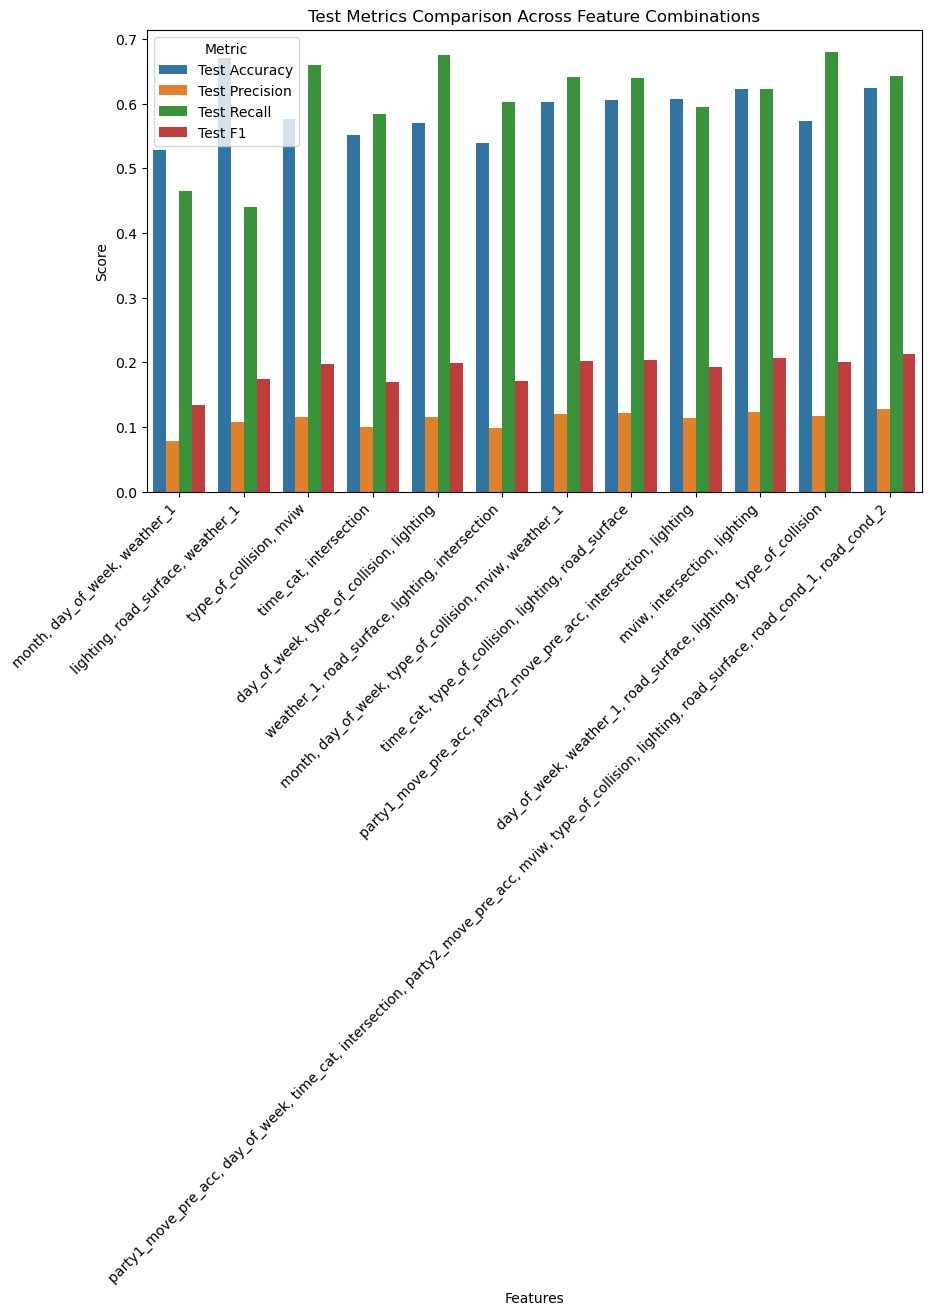

In [72]:
# # Melting the DataFrame
df_long = pd.melt(results_df, id_vars=['Features'], var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_long, x='Features', y='Score', hue='Metric')
plt.xticks(rotation=45, ha="right")
plt.title('Test Metrics Comparison Across Feature Combinations')
plt.tight_layout()
plt.show()


In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import numpy as np

# Define feature combinations
feature_combinations = [
    ['month', 'day_of_week', 'weather_1'],
    ['lighting', 'road_surface', 'weather_1'],
    ['type_of_collision', 'mviw'],
    ['time_cat', 'intersection'],
    ['day_of_week', 'type_of_collision', 'lighting'],
    ['weather_1', 'road_surface', 'lighting', 'intersection'],
    ['month', 'day_of_week', 'type_of_collision', 'mviw', 'weather_1'],
    ["party1_move_pre_acc","party2_move_pre_acc", "intersection", "lighting"],
    ['time_cat', 'type_of_collision', 'lighting', 'road_surface'],
    ['mviw', 'intersection', 'lighting'],
    ['day_of_week', 'weather_1', 'road_surface', 'lighting', 'type_of_collision'],
    ['party1_move_pre_acc','day_of_week','time_cat','intersection','party2_move_pre_acc','mviw','type_of_collision','lighting', 'road_surface',
       'road_cond_1', 'road_cond_2']
]

results = []

# Process for each feature set
for features in feature_combinations:
    X = crash_data[features]
    y = crash_data['level']

    # Encoding categorical variables, now handling unknown categories
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), features)
    ], remainder='passthrough')
    
    # Create a pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000))
    ])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    model.fit(X_train, y_train)

    # Get model coefficients and intercept
    clf = model.named_steps['classifier']
    params = np.append(clf.intercept_, clf.coef_.flatten())

    # Predict probabilities
    y_pred_prob = model.predict_proba(X_test)
    y_pred_log = np.log(y_pred_prob + 1e-15)  # add a small value to avoid log(0)

    # Compute Log-Likelihood
    log_likelihood = np.sum(y_test * y_pred_log[:, 1] + (1 - y_test) * y_pred_log[:, 0])

    # Calculate AIC, AICc, BIC
    n = len(y_test)
    k = len(params)  # count of parameters
    aic = -2 * log_likelihood + 2 * k
    aicc = aic + (2 * k ** 2 + 2 * k) / (n - k - 1)
    bic = -2 * log_likelihood + np.log(n) * k

    # Append results
    results.append({
        'Features': ', '.join(features),
        'AIC': aic,
        'AICc': aicc,
        'BIC': bic
    })

results_df = pd.DataFrame(results)
results_df


,Features,AIC,AICc,BIC
0,"month, day_of_week, weather_1",6496.117495,6496.299250,6731.743701
1,"lighting, road_surface, weather_1",6409.938811,6410.033746,6579.295147
2,"type_of_collision, mviw",6222.643409,6222.708740,6362.546469
3,"time_cat, intersection",6342.275181,6342.294078,6415.908370
4,"day_of_week, type_of_collision, lighting",6217.433037,6217.512480,6372.062735
5,"weather_1, road_surface, lighting, intersection",6377.489984,6377.610748,6568.936276
6,"month, day_of_week, type_of_collision, mviw, w...",6273.300685,6273.740264,6641.466632
7,"party1_move_pre_acc, party2_move_pre_acc, inte...",6290.325618,6290.819109,6680.581522
8,"time_cat, type_of_collision, lighting, road_su...",6196.379750,6196.482949,6373.099405
9,"mviw, intersection, lighting",6218.071555,6218.136886,6357.974614


In [78]:
features = ["mviw", "intersection", "lighting"]
X = df[features]
y = df['level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), features)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=1000))
])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  ['mviw', 'intersection',
                                                   'lighting'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='liblinear'))])

In [79]:
# Access the fitted LogisticRegression model
model = pipeline.named_steps['classifier']
import numpy as np

# Get the coefficients
coefficients = model.coef_[0]

# Correctly get feature names for scikit-learn 0.24 and later
feature_names = pipeline.named_steps['preprocessor'].named_transformers_['onehot'].get_feature_names_out()

# Map coefficients to feature names
coef_dict = dict(zip(feature_names, coefficients))

print("Model Coefficients:")
print("Odds - Severe Injury to Minor Injuries\n")

for feature, coef in coef_dict.items():
    odds = np.exp(coef)
    if odds>1.5:
        print(f"{feature}:{odds}")


Model Coefficients:
Odds - Severe Injury to Minor Injuries

mviw_Fixed Object:1.7364190478412629
mviw_Not Stated:1.5728427064268644
mviw_Other Object:1.6555857640522444
mviw_Pedestrian:1.861696239229779
lighting_Dark - Street Lights Not Functioning:1.5782455171799805
